# *lsforce* example script: Full parameterization
---

This example script produces the force-time function and associated trajectory for a very large ice–rock avalanche occurring on Iliamna Volcano, Alaska, USA, on 22 May 2016 (Toney et al., 2021). Here, we use the "full" model vector parameterization method, which imposes no constraints on the form of the force-time function. This example demonstrates how to use the built-in jackknife method to assess inversion stability under changing input data. It also shows how one can use the provided command [`axisem2cps`](https://code.usgs.gov/ghsc/lhp/lsforce/-/blob/main/lsforce/axisem2cps.py) to produce a CPS model file, and how CPS Green's function computation can be used as a more customizable alternative to Syngine (see discussion in the *lsforce* documentation [here](https://code.usgs.gov/ghsc/lhp/lsforce#installation)).

**References**

<p>
<div style="text-indent:-36px; padding-left:36px;">
<p>
Toney, L., Fee, D., Allstadt, K. E., Haney, M., & Matoza, R. S. (2021). Reconstructing the dynamics of the highly similar May 2016 and June 2019 Iliamna Volcano (Alaska) ice–rock avalanches from seismoacoustic data. <em>Earth Surface Dynamics, 9</em>(2), 271–293. <a href="https://doi.org/10.5194/esurf-9-271-2021">https://doi.org/10.5194/esurf-9-271-2021</a>
</p>
</div>

### Import necessary modules

In [1]:
from pathlib import Path

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth

from lsforce import LSData, LSForce, LSTrajectory

# Ignore benign Matplotlib backend warning due to fig.show()
import warnings
warnings.filterwarnings(action='ignore', message='Matplotlib is currently using module')

### Define some constants, set up folder structure

In [2]:
PERIOD_RANGE = (15, 80)  # [s] Bandpass filter corners

LS_LAT, LS_LON = (60.0273, -153.0683)  # Where the point force will be applied
ORIGIN_TIME = UTCDateTime(2016, 5, 22, 7, 57, 34)

STARTTIME = ORIGIN_TIME - 100
ENDTIME = ORIGIN_TIME + 300

# Set up folder structure
main_folder = Path.cwd() / 'iliamna_2016_paper'
if not main_folder.exists():
    main_folder.mkdir()

### Gather inversion waveforms

TA.N19K..BHE -> TA.N19K..BHE
{'azimuth': 90.1, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 16000 / 16000 (100%)
Max absolute difference: 2.0768844
Max relative difference: 1.93033165
 x: array([13.493983, 11.495731, 11.497477, ..., 81.415339, 80.41185 ,
       79.406616])
 y: array([12, 10, 10, ..., 80, 79, 78], dtype=int32)

TA.N19K..BHN -> TA.N19K..BHN
{'azimuth': 0.1, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 16000 / 16000 (100%)
Max absolute difference: 0.97235034
Max relative difference: 0.0016166
 x: array([855.977752, 856.981241, 857.98124 , ..., 810.859139, 808.860887,
       805.862637])
 y: array([856, 857, 858, ..., 811, 809, 806], dtype=int32)

ZE.WFLW..HHE -> ZE.WFLW..HHE
{'azimuth': 90.0, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
(shapes (39999,), (40000,) mismatch)
 x: array([587., 589., 588., ..., 583., 589., 576.])
 y: array([588, 587, 589, ..., 583, 589, 576], dtype=int32)

ZE.WFLW..HHN -> ZE.

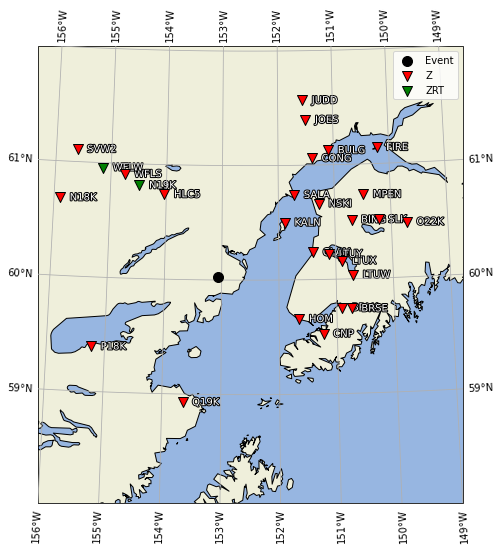

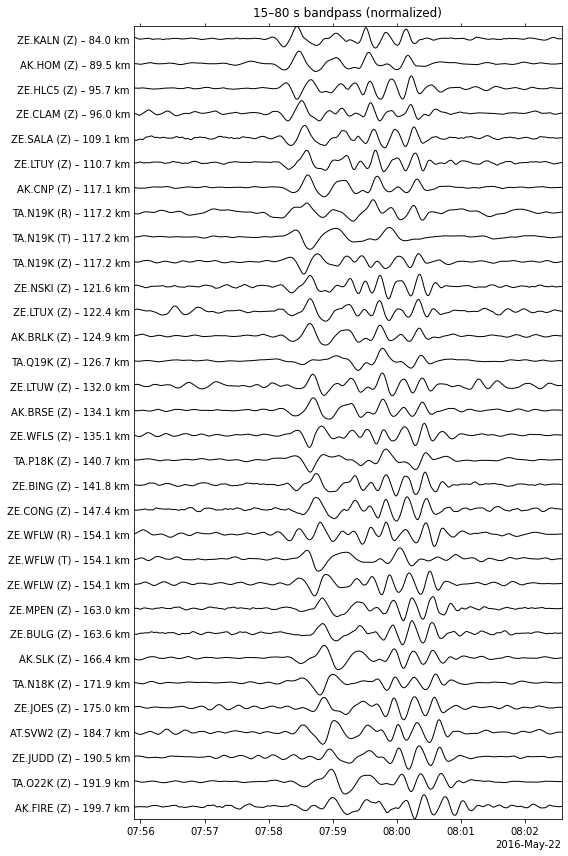

In [3]:
TONEY_ET_AL_NUM_CHANS = 32  # Number of channels used in paper's 2016 Iliamna inversion

data_filename = main_folder / 'data.pkl'

# Download data if it doesn't exist as a file
if not data_filename.exists():

    client = Client('IRIS')
    waveform_kwargs = dict(
        location='*', starttime=STARTTIME, endtime=ENDTIME, attach_response=True
    )

    # Gather vertical components (most of the waveforms!)
    NETWORKS = (
        'AK',
        'AT',
        'AV',
        'TA',
        'ZE',
    )
    STATIONS = (
        'KALN',
        'HOM',
        'HLC5',
        'CLAM',
        'SALA',
        'LTUY',
        'N19K',
        'CNP',
        'NSKI',
        'LTUX',
        'BRLK',
        'Q19K',
        'LTUW',
        'BRSE',
        'WFLS',
        'P18K',
        'BING',
        'CONG',
        'WFLW',
        'MPEN',
        'BULG',
        'SLK',
        'N18K',
        'JOES',
        'SVW2',
        'JUDD',
        'O22K',
        'FIRE',
    )
    st = client.get_waveforms(
        network=','.join(NETWORKS),
        station=','.join(STATIONS),
        channel='BHZ,HHZ',
        **waveform_kwargs,
    )

    # Gather horizontals (only a few)
    st += client.get_waveforms(
        network='TA', station='N19K', channel='BHE,BHN', **waveform_kwargs
    )
    st += client.get_waveforms(
        network='ZE', station='WFLW', channel='HHE,HHN', **waveform_kwargs
    )

    # Grab coordinates
    inv = client.get_stations(
        network=','.join(NETWORKS),
        starttime=STARTTIME,
        endtime=ENDTIME,
        level='channel',
    )

    # Assign coordinates to Traces
    for tr in st:
        coords = inv.get_coordinates(tr.id, datetime=STARTTIME)
        tr.stats.latitude = coords['latitude']
        tr.stats.longitude = coords['longitude']

    st.write(str(data_filename), format='PICKLE')

# Use file if it exists, for speed
else:
    st = read(str(data_filename), format='PICKLE')

# Verify that the correct number of channels has been retrieved from IRIS
assert st.count() == TONEY_ET_AL_NUM_CHANS, 'Not the correct number of channels.'

# Create LSData object
data = LSData(st, source_lat=LS_LAT, source_lon=LS_LON)

# Create plots
data.plot_stations(label_stations=True);
data.plot_data(equal_scale=False, period_range=PERIOD_RANGE);

### Gather reference waveforms

In [4]:
RAYLEIGH_VELO = 0.9  # [km/s] Surface-wave group velocity @ 1 Hz
INFRA_VELO = 0.337  # [km/s] Reasonable given air temp of 50 degrees F

client = Client('IRIS')

# Gather seismic
st_hf = client.get_waveforms(
    network='AV',
    station='ILSW',
    location='--',
    channel='BHZ',
    starttime=STARTTIME,
    endtime=ENDTIME,
    attach_response=True,
)
# Gather infrasound
st_infra = client.get_waveforms(
    network='TA',
    station='O20K',
    location='*',
    channel='BDF',
    starttime=STARTTIME,
    endtime=ENDTIME,
    attach_response=True,
)

# Combined processing
(st_hf + st_infra).remove_response()
(st_hf + st_infra).detrend('demean')
(st_hf + st_infra).taper(max_percentage=0.05)

# Separate filtering
st_hf.filter('bandpass', freqmin=0.5, freqmax=5)
st_infra.filter('bandpass', freqmin=0.5, freqmax=9.5)

# Add "distance" to tr.stats
ref_inv = client.get_stations(
    network='AV,TA',
    station='ILSW,O20K',
    starttime=STARTTIME,
    endtime=ENDTIME,
    level='channel',
)

for tr in st_hf + st_infra:
    coords = ref_inv.get_coordinates(tr.id, datetime=STARTTIME)
    tr.stats.latitude = coords['latitude']
    tr.stats.longitude = coords['longitude']
    dist = gps2dist_azimuth(LS_LAT, LS_LON, tr.stats.latitude, tr.stats.longitude)[0]
    tr.stats.distance = dist / 1000  # [km]

# Approximate correction for travel time
hf_shift = st_hf[0].stats.distance / RAYLEIGH_VELO
infra_shift = st_infra[0].stats.distance / INFRA_VELO

### Setup

This notebook uses Syngine to generate Green's functions. However, we include the steps needed to use CPS instead below.

The command `axisem2cps` can generate CPS model files from Syngine models. Running the command with no arguments prints a help message (the `!` tells Jupyter to interpret this as a shell "command-line" command and not a Python command):

In [5]:
!axisem2cps

Convert model files used for IRIS Syngine AxiSEM runs to
Computer Programs in Seismology (CPS) format.

Usage:
    axisem2cps <model>

Where <model> is one of:
    ak135f
    iasp91
    prem_crust20_ocean
    prem_ani
    prem_iso


For example, to generate a CPS model file `iasp91.mod` for use in this notebook, you can run the following:

In [6]:
!axisem2cps iasp91

iasp91.mod created (195 layers, maximum depth = 1490 km)


We can see that the resulting file has the proper CPS format:

In [7]:
!head -15 iasp91.mod

MODEL.01
AxiSEM input file "1dmodel_iasp91.txt" truncated to 1490 km (195 layers)
ISOTROPIC
KGS
SPHERICAL EARTH
1-D
CONSTANT VELOCITY
LINE08
LINE09
LINE10
LINE11
H(KM)    VP(KM/S)    VS(KM/S)    RHO(GM/CC)    QP    QS    ETAP    ETAS    FREFP    FREFS
20.0     5.8000     3.3600     2.7200    57827.0      600.0    0.0    0.0    1.0    1.0
15.0     6.5000     3.7500     2.9200    57827.0      600.0    0.0    0.0    1.0    1.0
 5.0     8.0400     4.4700     3.3198    57827.0      600.0    0.0    0.0    1.0    1.0


In the code cell below, `syngine_model` can be replaced with `cps_model` to have CPS compute the Green's functions.

In [8]:
force = LSForce(data=data, data_sampling_rate=1, main_folder=main_folder)

force.setup(
    period_range=PERIOD_RANGE,
    syngine_model='iasp91_2s',
#     cps_model='iasp91.mod',  # If this is uncommented, syngine_model must be commented or set to None
)

Resampled records are of differing lengths. Interpolating all records to same start time and sampling rate.
Getting Green's functions...
Found BING (1/28)
Found BRLK (2/28)
Found BRSE (3/28)
Found BULG (4/28)
Found CLAM (5/28)
Found CNP (6/28)
Found CONG (7/28)
Found FIRE (8/28)
Found HLC5 (9/28)
Found HOM (10/28)
Found JOES (11/28)
Found JUDD (12/28)
Found KALN (13/28)
Found LTUW (14/28)
Found LTUX (15/28)
Found LTUY (16/28)
Found MPEN (17/28)
Found N18K (18/28)
Found N19K (19/28)
Found NSKI (20/28)
Found O22K (21/28)
Found P18K (22/28)
Found Q19K (23/28)
Found SALA (24/28)
Found SLK (25/28)
Found SVW2 (26/28)
Found WFLS (27/28)
Found WFLW (28/28)


### Invert

In [9]:
force.invert(
    zero_time=122,
    impose_zero_start=True,
    add_to_zero=True,
    jackknife=True,
    num_iter=20,
    frac_delete=0.3,
    alpha=4.8e-17,
    zero_scaler=5,
    tikhonov_ratios=(0.4, 0.0, 0.6),
)

Variance reduction = 83.685829 percent
Starting jackknife iterations
Jackknife VR stats: max 85, min 80, median 83


### Plot inversion

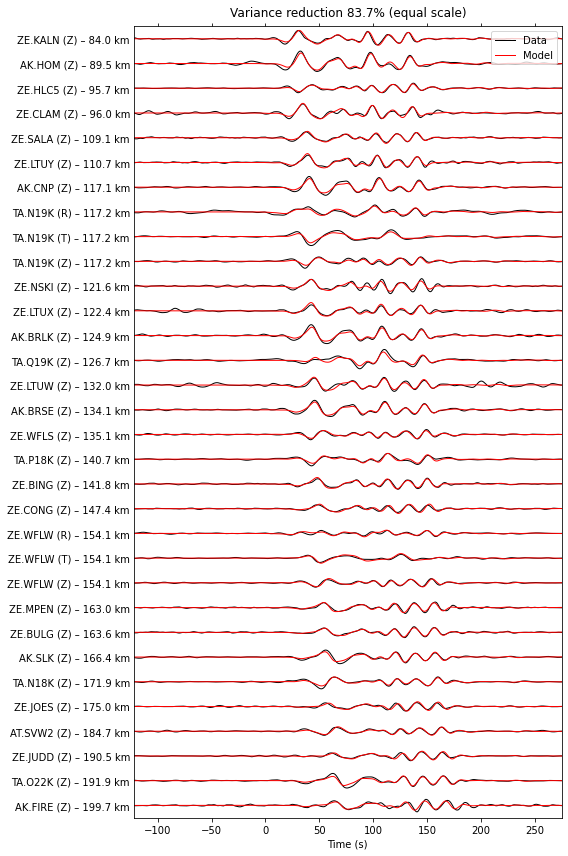

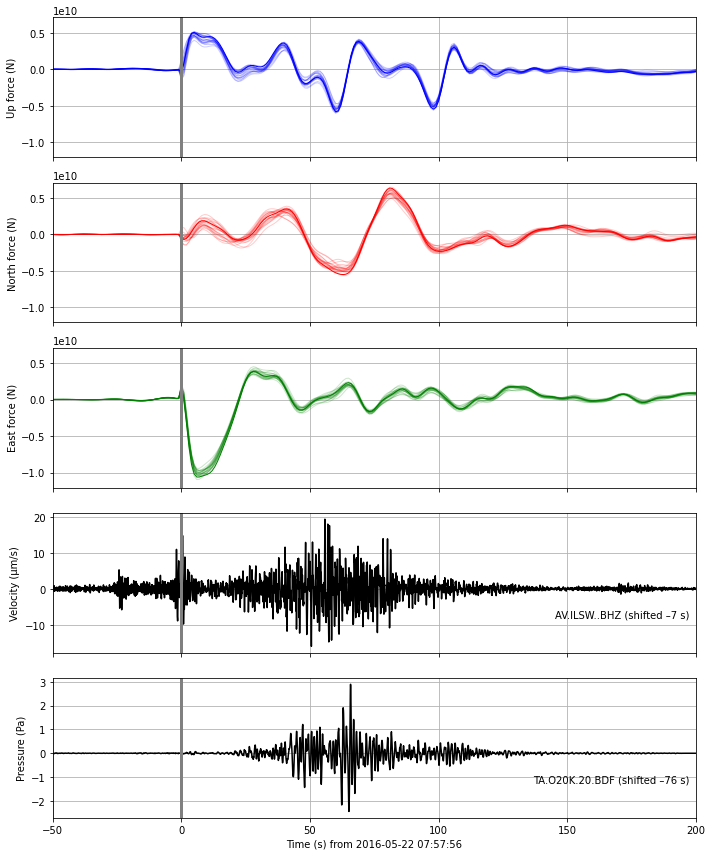

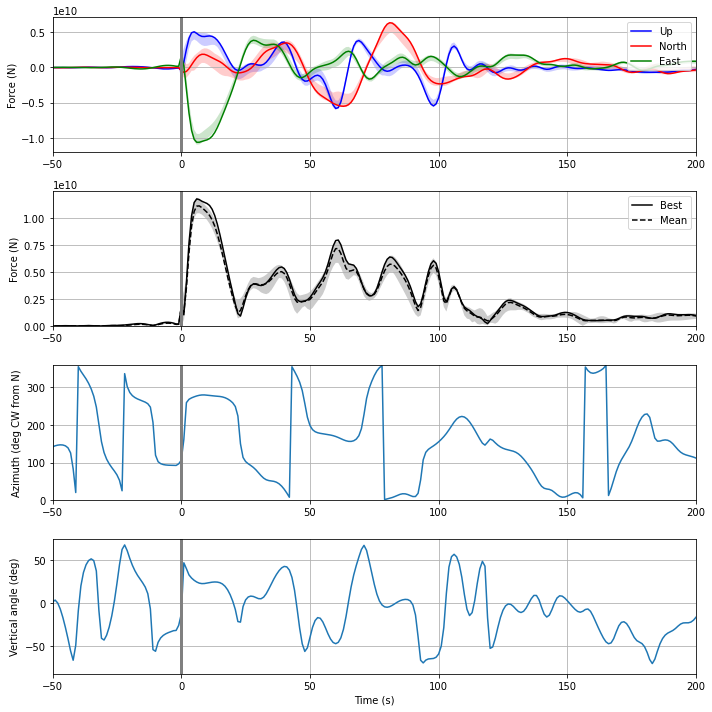

In [10]:
XLIM = (-50, 200)  # [s] x-axis (time) limits for plots

# Plot inversion waveform fits and results
force.plot_fits();
force.plot_forces(
    highf_tr=st_hf[0],
    hfshift=hf_shift,
    infra_tr=st_infra[0],
    infra_shift=infra_shift,
    jackshowall=True,
    xlim=XLIM,
    subplots=True,
);
force.plot_angle_magnitude(xlim=XLIM);

### Compute trajectory

In [11]:
L = 5.8  # [km] Estimate of horizontal COM runout length

trajectory = LSTrajectory(
    force, target_length=L, duration=XLIM[1], detrend_velocity=XLIM[1],
)

### Plot trajectory

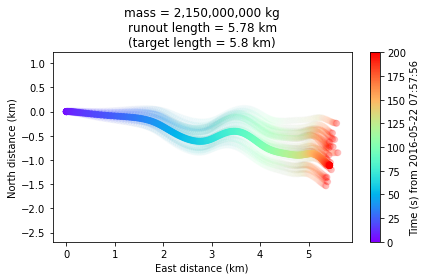

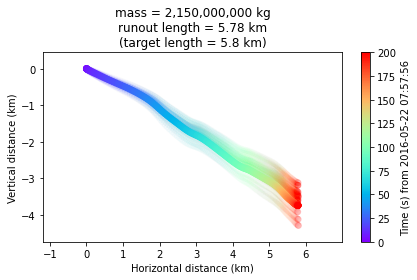

In [12]:
trajectory.plot_trajectory(plot_jackknife=True);
trajectory.plot_trajectory(plot_jackknife=True, elevation_profile=True);